# Project 2
- **Student**: Nunzio D'Amore
- **Student ID**: 329163
## Least Square Method
### Data Description
This project concerns the estimation of the parameters of a function based on independent triplettes:
(x, y_mean, y_err)
- **x**: the x value.
- **y_mean**: the y value.
- **y_err**: the std of the y measurement.

We suppose the y is a function of x.
We will use three hypotesis functions:
1.   $y = \theta_1 \cdot x^{\theta_2}$
2.   $y = \theta_1 + \theta_2x + \theta_3x^2$
3.   $y = \theta_1 + \theta_2x + \theta_3e^x$

### Methodology
The parameters will be enstimated using least square method. This will be achieved using two approaches:
1. **Numerical approach**: using curve_fit method
2. **Analytical approach**: 

    Where: 
    - $V$ is the covariance matrix.
    - $A$ is the Vandermonde matrix.
    - $\bar{y}$ is the measurements vector.
    
    The following formula will be used to compute the parameters:
    $$ \bar{\hat{\theta}} = (A^TV^{-1}A)^{-1}A^TV^{-1}\bar{y}$$

    In this case the covariance matix will be computed using the following formula:
    $$ U = (A^TV^{-1}A)^{-1}$$

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))


import inspect
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plot_settings as plot_settings
import sympy as sp

In [2]:
'''
get_parameters_count returns the number of
parameters of a given lambda function

Ex. passing get_parameters_count lambda x, t0, t1, t2 : t0 + t1 * x + t2 * np.e**x
will return 4
'''
def get_parameters_count(function):
    return len(inspect.signature(function).parameters)

'''
get_t_parameters extracts a sorted list of t parameters 
in the given expression

Input: The input parameters is a string expression
Output: The output is a sorted list of strings

Ex. passing parse_lambda the string "t0 + t1 * x + t2 * e^x"
will return: ["t0", "t1", "t2"]
'''
def get_t_parameters(expression):
    # Extracting t parameters as a sorted set
    return sorted(
        set(re.findall(r't\d+', expression)), 
        key=lambda x: int(x[1:])
    )

'''
parse_lambda can extract a lambda function
from a given string expression.

It recognizes as function parameters only x and t.

Input: The input parameters is a string expression
Output: The output is a lambda function

Ex. passing parse_lambda the string "t0 + t1 * x + t2 * e^x"
evaluates in: lambda x, t0, t1, t2 : t0 + t1 * x + t2 * np.e**x
'''
def parse_lambda(expression):
    # Extracting t parameters
    t_vars = get_t_parameters(expression)

    # Creating parameters string with x in the beginning
    lambda_params = ['x'] + t_vars    
    string_params = ', '.join(lambda_params)
    
    string_lambda = f"lambda {string_params} : {expression}"

    # Replacing exponential expressions to make them compatible with Python syntax
    replacements = [
        ("e","np.e"),
        ("^","**"),
        ("log","np.log"),
    ]

    for replacement in replacements:
        string_lambda = string_lambda.replace(*replacement)
        
    lambda_func = eval(string_lambda)

    return lambda_func


'''
extract_vandermonde_matrix This function extract the Vandermonde matrix 
used to analytically compute the least square method.

Input: 
    - expression: a string representing the given expression
    - x: the data on wich one wants to apply the least square method
Output: The output is the A matrix

Ex. passing parse_lambda:
    - expression:  "t0 + t1 * x + t2 * x^2"
    - x: [x1,x2,x3]

    will return the following A matrix:
    [[1, x1, x1**2]
     [1, x2, x2**2]
     [1, x3, x3**2]]
'''
def extract_vandermonde_matrix(expression, x):
    # Getting added terms
    no_spaces_expression = expression.replace(" ", "")
    splitted_terms = no_spaces_expression.split("+")

    # Getting t parameters
    t_params = get_t_parameters(expression)

    base_terms = []

    for term in splitted_terms:
        # Removing t parameters
        for t in t_params:
            term = term.replace(t, "")
            term = term.replace("*", "")
        
        # If term is empty x is not present
        # replacing the empty term with 1
        if(term == ''):
            term = "1"
            
        # Parsing lambda so we can later evaluate it
        base_terms.append(parse_lambda(term))

    A = []
    # Evaluating lambda functions with given data
    # to compute the A matrix
    for x_value in x:
        a = [lambda_term(x_value) for lambda_term in base_terms]
        A.append(a)
    A = np.array(A)

    return A

In [3]:
# FITTING FUNCTIONS

# Chi-square
def chi2(y_obs, y_pred, y_err):
    return np.sum(((y_obs - y_pred) / y_err) ** 2)

# analytic_covariance_matrix computes analitically
# the covariance matrix
def analytic_covariance_matrix(A, V_inv):
    return np.linalg.inv(A.T @ V_inv @ A)
    
''' 
analytic_least_square apply the least square method
analytically.

Input:
    - expression: string expression to fit
    - x: x axes values of the data to fit
    - y: y axes values of the data to fit
    - y_err: std of each y value
Output:
    - the corresponding lamba of the given expression 
    - the optimal parameters for the expression
    - the covariance matrix of the parameters
'''
def analytic_least_square(expression, x, y, y_err):
    # Computing V
    V = np.eye(len(y_err)) * (y_err ** 2)
    V_inv = np.linalg.inv(V)

    # Computing A and
    A = extract_vandermonde_matrix(expression, x)

    # Computing B matrix
    B = np.linalg.inv(A.T @ V_inv @ A) @ A.T @ V_inv

    # Computing optimal parameters
    opt_params = B@y

    # Computing covariance matrix
    cov_matrix = analytic_covariance_matrix(A, V_inv)

    return parse_lambda(expression), opt_params, cov_matrix
    

''' 
numeric_least_square apply the least square method
numerically using curve_fit.

Input:
    - expression: string expression to fit
    - x: x axes values of the data to fit
    - y: y axes values of the data to fit
    - y_err: std of each y value
Output:
    - the corresponding lamba of the given expression 
    - the optimal parameters for the expression
    - the covariance matrix of the parameters
'''
def numeric_least_square(expression, x, y, y_err, ):
    func = parse_lambda(expression)
    parameters_count = get_parameters_count(func) - 1 # Excluding x
    initial_guess = [1] * parameters_count

    opt_parameters, cov_matrix = curve_fit(func, x, y, sigma=y_err, p0=initial_guess, absolute_sigma=True)
    
    return func, opt_parameters, cov_matrix

In [4]:

# Reading data
data_df = pd.read_csv('data.txt', sep='\t')

# Hypothesized functions
# The content is a list of tuple
# (Expression, Method)
# Expression is the given expression
# Method can be:
#   - 'analitically'
#   - 'numerically'
expressions = [
    ("t0 * x^t1", 'numerically'),
    ("t0 + t1 * x + t2 * x^2", 'analitically'),
    ("t0 + t1 * x + t2 * e^x", 'analitically'),
]

In [5]:
# Splitting data
x = data_df["x"].values
y = data_df["y_mean"].values
y_err = data_df["std"].values

results = []

# Fitting functions with LS
for expression, method in expressions:
    if method == 'analitically':
        extracted_function, opt_params, cov_matrix = analytic_least_square(expression, x, y, y_err)                                                                       
    elif method == 'numerically':
        extracted_function, opt_params, cov_matrix = numeric_least_square(expression, x, y, y_err)
    else: 
        print(f"[WARNING] Wrong method passed: '{method}'. Use 'analitically' or 'numerically' instead.")

    
    # Adding results
    results.append((expression, extracted_function, opt_params, cov_matrix))



Results:
y = t0 * x^t1

Optimal parameters: 
	t0 = 1.777 
	t1 = 1.787 

Covariance matrix:
[[ 0.04829141 -0.01886755]
 [-0.01886755  0.00750211]]

Chi-square: 30.293362572388766
Pearson: 4.327623224626967
y = t0 + t1 * x + t2 * x^2

Optimal parameters: 
	t0 = 4.357 
	t1 = -2.389 
	t2 = 1.621 

Covariance matrix:
[[ 1.1805829  -0.96442032  0.16115283]
 [-0.96442032  0.93241416 -0.16687303]
 [ 0.16115283 -0.16687303  0.03103957]]

Chi-square: 9.119415622568372
Pearson: 1.5199026037613954
y = t0 + t1 * x + t2 * e^x

Optimal parameters: 
	t0 = 1.140 
	t1 = 2.202 
	t2 = 0.175 

Covariance matrix:
[[ 6.47354040e-01 -3.38771462e-01  1.02053061e-02]
 [-3.38771462e-01  2.26255278e-01 -8.09593803e-03]
 [ 1.02053061e-02 -8.09593803e-03  3.43211024e-04]]

Chi-square: 4.68527790248105
Pearson: 0.7808796504135084


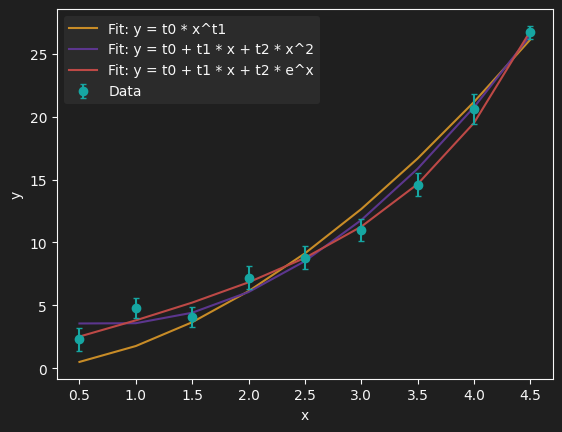

In [6]:
# Showing results
print("\nResults:")

fig, ax= plot_settings.figure_ax()
pearson_test = []

# Plotting fitted functions
for color_index, result in enumerate(results):
    expression = result[0]
    function = result[1]
    opt_params = result[2]
    cov_matrix = result[3]

    string_opt_params = ""
    for i, value in enumerate(opt_params):
        string_opt_params += f"\n\tt{i} = {value:.3f} "



    y_pred = function(x, *opt_params)

    # Pearson chi2 test
    chi2_value = chi2(y, y_pred, y_err)
    deg_freedom = len(y) - (get_parameters_count(function) - 1)
    p_value = chi2_value / deg_freedom
    
    pearson_test.append((expression,p_value))
    print("===========================================")
    print(f"y = {expression}", end="\n\n")
    print(f"Optimal parameters: {string_opt_params}", end="\n\n")

    print("Covariance matrix:")
    print(cov_matrix, end="\n\n")

    print(f"Chi-square: {chi2_value}")
    print(f"Pearson: {p_value}")
    ax.plot(x, function(x, *opt_params), label=f'Fit: y = {expression}', c=plot_settings.color(color_index))
    
print("===========================================")

# Plotting data
ax.errorbar(x, y, yerr=y_err, fmt='o', label='Data', capsize=2, c= "#16A6A2")

plot_settings.set_plot_theme(ax)


In [53]:
# Pearson test

# Selecting best fitting function
# getting the one that has the pearson
# test value nearest to 1
best_index = -1
last_distance = -1
for index, test in enumerate(pearson_test):
    p_value = test[1] 
    quadratic_distance_from_one = ((p_value - 1) ** 2)
    if quadratic_distance_from_one < last_distance or best_index == -1:
        best_index = index
        last_distance = quadratic_distance_from_one

print("Best fitting function")
print(f"y = {pearson_test[best_index][0]}")
    


Best fitting function
y = t0 + t1 * x + t2 * e^x
